# cosmoprimo examples

## Cosmology

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from cosmoprimo import *

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:
# Start with some vanilla cosmology
cosmo = Cosmology()
# Planck2018 TT, TE, EE, lowE, lensing and BAO data
cosmo_planck = fiducial.Planck2018FullFlatLCDM()
# Custom cosmology
cosmo_custom = Cosmology(omega_cdm=0.2, sigma8=0.7)
print('One can provide the following parameters (including conflicts):',
      cosmo.get_default_params(include_conflicts=True))

One can provide the following parameters (including conflicts): {'h': 0.7, 'Omega_cdm': 0.25, 'Omega_b': 0.05, 'Omega_k': 0.0, 'sigma8': 0.8, 'k_pivot': 0.05, 'n_s': 0.96, 'alpha_s': 0.0, 'beta_s': 0.0, 'r': 0.0, 'n_t': 'scc', 'alpha_t': 'scc', 'T_cmb': 2.7255, 'm_ncdm': None, 'neutrino_hierarchy': None, 'T_ncdm_over_cmb': 0.71611, 'N_eff': 3.044, 'tau_reio': 0.06, 'reionization_width': 0.5, 'A_L': 1.0, 'w0_fld': -1.0, 'wa_fld': 0.0, 'cs2_fld': 1.0, 'H0': 0.7, 'omega_cdm': 0.25, 'Omega0_cdm': 0.25, 'Omega_c': 0.25, 'omega_c': 0.25, 'Omega_m': 0.25, 'omega_m': 0.25, 'Omega0_m': 0.25, 'omega_b': 0.05, 'Omega0_b': 0.05, 'A_s': 0.8, 'logA': 0.8, 'ln10^{10}A_s': 0.8, 'ln10^10A_s': 0.8, 'ln_A_s_1e10': 0.8, 'Omega_g': 2.7255, 'omega_g': 2.7255, 'Omega0_g': 2.7255, 'Omega_ncdm': None, 'omega_ncdm': None, 'Omega0_ncdm': None, 'N_ur': 3.044, 'Omega_ur': 3.044, 'omega_ur': 3.044, 'Omega0_ur': 3.044, 'z_reio': 0.06, 'non_linear': '', 'modes': 's', 'lensing': False, 'z_pk': None, 'kmax_pk': 10.0, '

In [3]:
# Input and easily derived parameters can be accessed through indexing
print('h', cosmo['h'], cosmo_custom['h'])
print('Omega_cdm', cosmo['Omega_cdm'], cosmo_custom['Omega_cdm'])

h 0.7 0.7
Omega_cdm 0.25 0.4081632653061225


In [4]:
# One can clone any cosmology, to update any parameter, e.g.
cosmo_cloned = cosmo_custom.clone(sigma8=1.)
# Check out clone options, especially the part about 'base'
help(cosmo_custom.clone)
assert cosmo_cloned['sigma8'] == 1.

Help on method clone in module cosmoprimo.cosmology:

clone(base='input', engine=None, extra_params=None, **params) method of cosmoprimo.cosmology.Cosmology instance
    Clone current cosmology instance, optionally updating engine and parameters.
    
    Parameters
    ----------
    base : string, default='input'
        If 'internal' or ``None``, update parameters in the internal :math:`h, \Omega, m_{cdm}` basis.
        If, e.g. input parameters are :math:`h, \omega_{b}, \omega_{cdm}`, ``clone(base='internal', h=0.7)``
        returns the same cosmology, but with :math:`h = 0.7`; since :math:`\Omega_{b}, \Omega_{cdm}` are kept fixed,
        :math:`\omega_{b}, \omega_{cdm}` are modified.
        If 'input', update input parameters.
        With ``clone(base='input', h=0.7)`` :math:`\omega_{b}, \omega_{cdm}` are left unchanged,
        but :math:`\Omega_{b}, \Omega_{cdm}` are modified.
    
    engine : string, default=None
        Engine name, one of ['class', 'camb', 'eisenstein_h

## Fiducial cosmologies

In [5]:
# Some fiducial cosmologies are provided, e.g.:
from cosmoprimo.fiducial import Planck2018FullFlatLCDM, AbacusSummit, DESI, TabulatedDESI
cosmo = DESI()
assert cosmo == AbacusSummit()
# All AbacusSummit cosmologies (https://github.com/abacusorg/AbacusSummit/tree/master/Cosmologies)
# are accessible through AbacusSummit(cosmology_number)
assert AbacusSummit(1) == AbacusSummit('001') and cosmo != AbacusSummit('001')
cosmo_tabulated = TabulatedDESI()  # tabulated z-> distance relation, does not require any engine
z = np.linspace(0., 10., 1000)
assert np.allclose(cosmo_tabulated.comoving_radial_distance(z), cosmo.comoving_radial_distance(z), rtol=1e-5)

## Engines & sections

In [6]:
# Cosmological calculation is performed by engines, by section 
# (Background, Thermodynamics, Primordial, Perturbations, Transfer, Harmonic, Fourier)
# Engines can be set once for all sections as:
cosmo = Cosmology(engine='class')
# or:
cosmo.set_engine('camb')
# or one can pass an engine instance directly
cosmo.set_engine(engine=cosmo.engine) # CLASS engine was attached to cosmo with the previous call
# then one does not need to specify it when calling specific section, e.g.
ba = cosmo.get_background()
# or:
ba = Background(cosmo)
# One can temporarily switch to another engine with:
ba = cosmo.get_background(engine='camb', set_engine=False)
# or:
ba = Background(cosmo,engine='camb', set_engine=False)
assert cosmo.engine is not ba.engine # class engine

## Shortcuts

In [7]:
# One can directly access a quantity existing in a single section, e.g.:
cosmo = Cosmology(engine='class')
z = 0.2
d = cosmo.comoving_radial_distance(z)
# is equivalent to cosmo.get_background().comoving_radial_distance(z)
assert np.all(d == cosmo.get_background().comoving_radial_distance(z))
# However, one will get into troubles if some attributes/methods 
# of e.g. section "Fourier" are the same as section "Fourier" (e.g. "table")
assert 'table' in dir(cosmo.get_transfer())
assert 'table' in dir(cosmo.get_fourier())
# Note that available attributes/methods are accessible through dir():
print('Attributes/methods available with class engine are {}'.format(dir(cosmo)))
# and their doc is given by .__doc__, e.g.
print(cosmo.comoving_radial_distance.__doc__)
# Available attributes/methods can be different with a different engine, e.g.
assert set(dir(cosmo)) != set(dir(Cosmology(engine='eisenstein_hu')))

Attributes/methods available with class engine are ['A_s', 'H0', 'K', 'N_eff', 'N_ncdm', 'N_ur', 'Omega0_Lambda', 'Omega0_b', 'Omega0_cdm', 'Omega0_dcdm', 'Omega0_de', 'Omega0_fld', 'Omega0_g', 'Omega0_k', 'Omega0_m', 'Omega0_ncdm', 'Omega0_ncdm_tot', 'Omega0_pncdm', 'Omega0_pncdm_tot', 'Omega0_r', 'Omega0_ur', 'Omega_Lambda', 'Omega_b', 'Omega_cdm', 'Omega_dcdm', 'Omega_de', 'Omega_fld', 'Omega_g', 'Omega_k', 'Omega_m', 'Omega_ncdm', 'Omega_ncdm_tot', 'Omega_pncdm', 'Omega_pncdm_tot', 'Omega_r', 'Omega_ur', 'T0_cmb', 'T0_ncdm', 'T_cmb', 'T_ncdm', 'YHe', '_RH0_', '__copy__', '__getattr__', '__getitem__', '__getstate__', '__pyx_vtable__', '_check_pk_of', '_compile_params', '_conflict_parameters', '_default_calculation_parameters', '_default_cosmological_parameters', '_derived', '_engine', '_extra_params', '_get_p_ncdm', '_get_rho_ncdm', '_get_z', '_has_fld', '_index_pk_of', '_input_params', '_params', '_use_pk_non_linear', 'age', 'alpha_s', 'alpha_t', 'angular_diameter_distance', 'angul

## Save/load

In [8]:
# One can save/load any cosmology instance this way:
import os
import tempfile

with tempfile.TemporaryDirectory() as tmp_dir: # in a temporary file to avoid messing up our directory
    fn = os.path.join(tmp_dir, 'cosmo.npy')
    cosmo.save(fn)
    cosmo2 = Cosmology.load(fn)

for param in cosmo.get_params():
    if isinstance(cosmo[param], np.ndarray):
        assert np.all(cosmo2[param] == cosmo[param])
    else:
        assert cosmo2[param] == cosmo[param]
# Note however that this will not save any calculated quantity

## Background

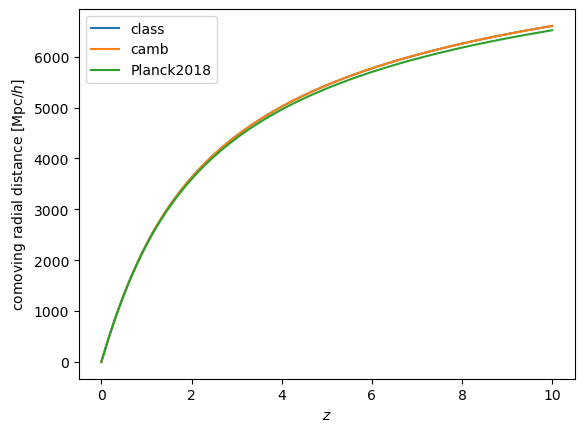

In [9]:
# One can choose an engine ('class', 'camb', 'eisenstein_hu' for approximations) for the calculation
# Do ba = Background(cosmo, engine='class') or:
ba = cosmo.get_background(engine='class') # e.g. precision parameters can be passed as other arguments
ba_camb = Background(cosmo, engine='camb') # alternative way of getting background
z = np.linspace(0., 10., 1000)
plt.plot(z, ba.comoving_radial_distance(z), label='class')
plt.plot(z, ba_camb.comoving_radial_distance(z), label='camb')
plt.plot(z, cosmo_planck.get_background(engine='class').comoving_radial_distance(z), label='Planck2018')
# Redoing cosmo_planck.get_background(engine='class') will not recompute the background, it's saved one for all!
# (cosmology instance is immutable)
plt.xlabel(r'$z$')
plt.ylabel(r'comoving radial distance [$\mathrm{Mpc}/h$]')
plt.legend()
plt.show()

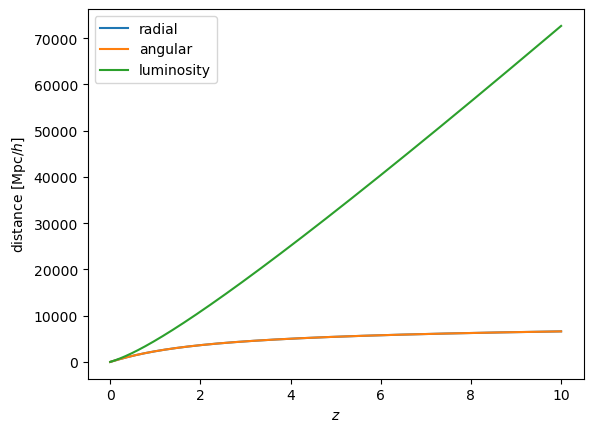

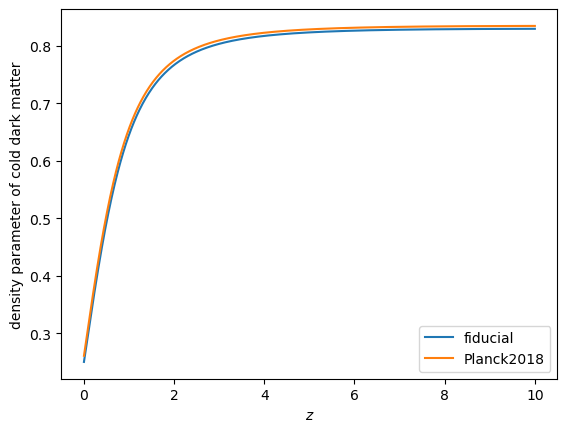

In [10]:
# Many quantities are available: distances, densities;
# Look at the doc (for class, look at http://github.com/adematti/pyclass)
plt.plot(z, ba.comoving_radial_distance(z), label='radial')
plt.plot(z, ba.comoving_angular_distance(z), label='angular')
plt.plot(z, ba.luminosity_distance(z), label='luminosity')
plt.xlabel(r'$z$')
plt.ylabel(r'distance [$\mathrm{Mpc}/h$]')
plt.legend()
plt.show()

plt.plot(z, ba.Omega_cdm(z), label='fiducial')
plt.plot(z, cosmo_planck.get_background(engine='class').Omega_cdm(z), label='Planck2018')
plt.xlabel(r'$z$')
plt.ylabel(r'density parameter of cold dark matter')
plt.legend()
plt.show()

## One can also access thermodynamics quantities (``cosmo.get_thermodynamics()``), primordial quantities, etc. Let's move to...

## Perturbations

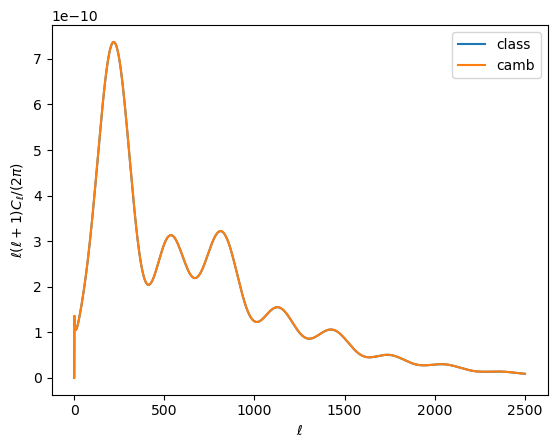

In [11]:
hr = Harmonic(cosmo,engine='class')
cls = hr.unlensed_cl()
ells_factor = (cls['ell'] + 1) * cls['ell'] / (2 * np.pi)
plt.plot(cls['ell'], ells_factor * cls['tt'], label='class')
hr = cosmo.get_harmonic(engine='camb') # second initialisation style
cls = hr.unlensed_cl() # same number of cells are output than in CLASS
plt.plot(cls['ell'], ells_factor * cls['tt'], label='camb')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell(\ell+1)C_{\ell}/(2\pi)$')
plt.legend()
plt.show()
# To get lensed_cl(), set lensing=True as part of the Cosmology arguments

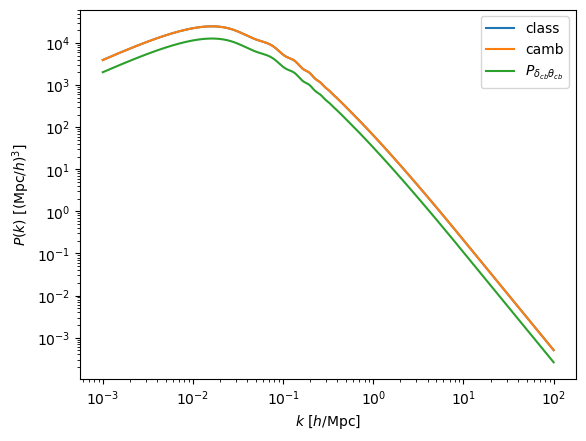

In [12]:
fo = Fourier(cosmo, engine='class')
pk = fo.pk_interpolator()
k = np.logspace(-3, 2, 1000)
z = 0
plt.loglog(k, pk(k, z=z), label='class')
fo_camb = cosmo.get_fourier(engine='camb') # second initialisation style
pk = fo_camb.pk_interpolator() # same number of cells are output than in CLASS
plt.loglog(k, pk(k, z=z), label='camb')
# cross density-velocity CDM + baryon power spectrum
plt.loglog(k,fo.pk_interpolator(of=('delta_cb', 'theta_cb'))(k, z=z), label=r'$P_{\delta_{cb}\theta_{cb}}$')
plt.xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
plt.ylabel(r'$P(k)$ [$(\mathrm{Mpc}/h)^{3}$]')
plt.legend()
plt.show()

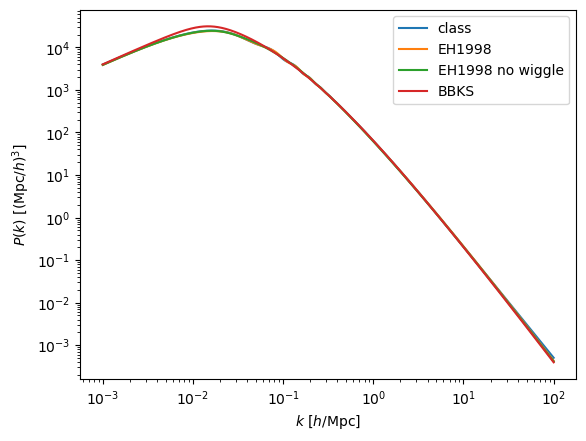

In [13]:
# Fast approximations
pk = fo.pk_interpolator()
plt.loglog(k, pk(k, z=z), label='class')
plt.loglog(k, Fourier(cosmo, 'eisenstein_hu').pk_interpolator()(k, z=z), label='EH1998')
plt.loglog(k, Fourier(cosmo, 'eisenstein_hu_nowiggle').pk_interpolator()(k, z=z), label='EH1998 no wiggle')
plt.loglog(k, Fourier(cosmo, 'bbks').pk_interpolator()(k, z=z), label='BBKS')
plt.xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
plt.ylabel(r'$P(k)$ [$(\mathrm{Mpc}/h)^{3}$]')
plt.legend()
plt.show()

## Note about $f\sigma_{8}$: better computed as the r.m.s. of velocity perturbations

In [14]:
fo = Fourier(cosmo, engine='class')
print('fsigma8 is',fo.sigma8_z(z=0, of='theta_cb'))

fsigma8 is 0.4102083350952247


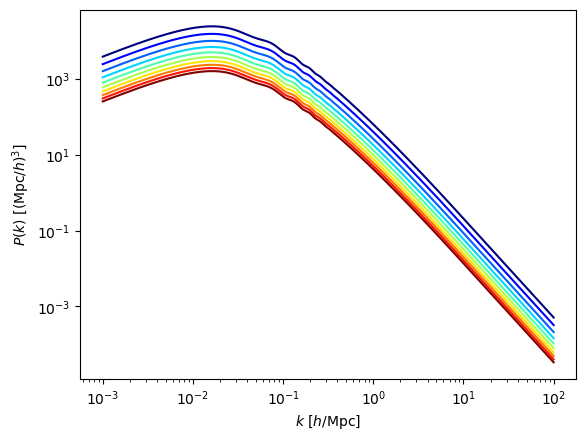

In [15]:
# As a function of z
k = np.logspace(-3, 2, 1000)
z = np.linspace(0., 4., 10)
colors = plt.cm.jet(np.linspace(0, 1, len(z)))
for zz, color in zip(z, colors):
    plt.loglog(k, pk(k, z=zz), color=color)
plt.xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
plt.ylabel(r'$P(k)$ [$(\mathrm{Mpc}/h)^{3}$]')
plt.show()

## Interpolators: easy handling of $P(k)$ / $\xi(s)$

In [16]:
# 2D (k,z) interpolator (vectorized, of course)
pk = fo.pk_interpolator()
k, z = 0.1, 1.
print('2D power spectrum at k = {}, z = {} is {}'.format(k, z, pk(k,z)))
# cast to 1D z interpolator (tiny interpolation error)
pk1d = pk.to_1d(z=z)
print('1D power spectrum at k = {}, z = {} is {}'.format(k, z, pk1d(k)))
# interpolators can be built from callables, e.g.
pk1dc = PowerSpectrumInterpolator1D.from_callable(pk_callable=pk1d)
print('1D power spectrum from callable at k = {}, z = {} is {}'.format(k, z, pk1dc(k)))

2D power spectrum at k = 0.1, z = 1.0 is 1978.8527724506928
1D power spectrum at k = 0.1, z = 1.0 is 1978.8527724506928
1D power spectrum from callable at k = 0.1, z = 1.0 is 1978.8527724506928


In [17]:
# Get sigma_rz() (vectorised)
r, z = 2., 1.
print('quadpack integration sigmarz = {} v.s. FFTlog sigmarz = {}'.format(pk.sigma_rz(r, z, nk=None), pk.sigma_rz(r, z)))
# Estimate fsigma_rz()
print('quadpack integration fsigmarz = {} v.s. FFTlog fsigmarz = {}'.format(pk.growth_rate_rz(r, z, nk=None), pk.growth_rate_rz(r, z)))

quadpack integration sigmarz = 1.0793257191938959 v.s. FFTlog sigmarz = 1.0793223221779205
quadpack integration fsigmarz = 0.8690213051936735 v.s. FFTlog fsigmarz = 0.8689110489542018


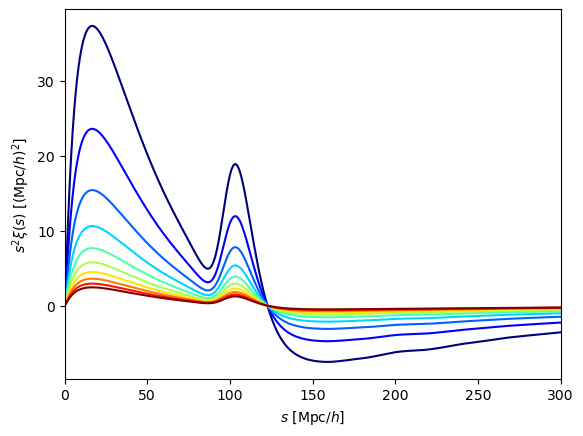

In [18]:
# FFTlog transform (vectorised) to xi...
xi = pk.to_xi()
s = np.logspace(-2., 2.5, 1000)
z = np.linspace(0., 4., 10)
colors = plt.cm.jet(np.linspace(0, 1, len(z)))
for zz, color in zip(z, colors):
    plt.plot(s, s**2 * xi(s, z=zz), color=color)
plt.xlim(0., 300.)
plt.xlabel(r'$s$ [$\mathrm{Mpc}/h$]')
plt.ylabel(r'$s^{2}\xi(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
plt.show()

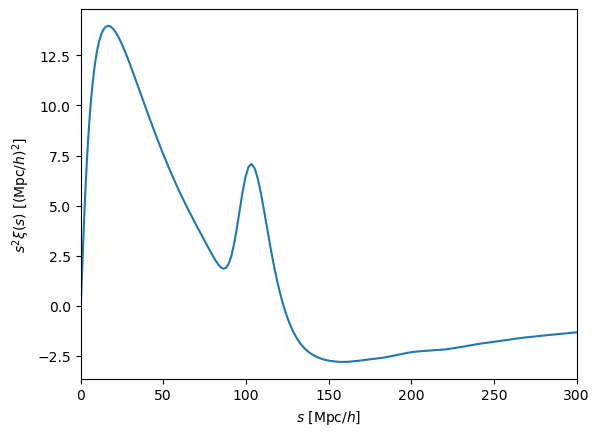

In [19]:
# This is equivalent to using PowerToCorrelation
from cosmoprimo import PowerToCorrelation

k = np.geomspace(pk1d.extrap_kmin, pk1d.extrap_kmax, 1024)
fftlog = PowerToCorrelation(k, ell=0)
s, xi1d = fftlog(pk1d(k))
plt.plot(s, s**2 * xi1d)
plt.xlim(0., 300.)
plt.xlabel(r'$s$ [$\mathrm{Mpc}/h$]')
plt.ylabel(r'$s^{2}\xi(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
plt.show()     

## BAO filters

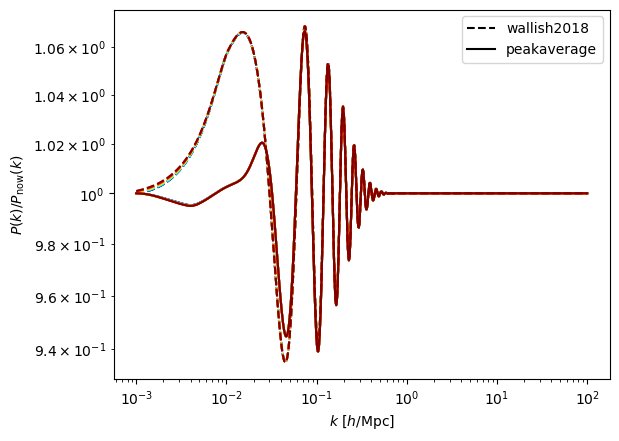

In [20]:
# Several engines are available for the power spectrum, but wallish2018 and peakaverage seem the most accurate one
# peakaverage has smooth dependence on cosmological parameters (useful for taking derivatives)
# Note one can also provide a 1D power spectrum interpolator
pknow_wallish = PowerSpectrumBAOFilter(pk, engine='wallish2018').smooth_pk_interpolator()
pknow_brieden = PowerSpectrumBAOFilter(pk, engine='peakaverage', cosmo=cosmo, cosmo_fid=cosmo).smooth_pk_interpolator()
k = np.logspace(-3, 2, 1000)
z = np.linspace(0., 4., 10)
colors = plt.cm.jet(np.linspace(0, 1, len(z)))
plt.plot([], [], linestyle='--', color='k', label='wallish2018')
plt.plot([], [], linestyle='-', color='k', label='peakaverage')
for zz, color in zip(z, colors):
    plt.loglog(k, pk(k, z=zz) / pknow_wallish(k, z=zz), color=color, linestyle='--')
    plt.loglog(k, pk(k, z=zz) / pknow_brieden(k, z=zz), color=color, linestyle='-')
plt.xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
plt.ylabel(r'$P(k)/P_{\mathrm{now}}(k)$')
plt.legend()
plt.show()

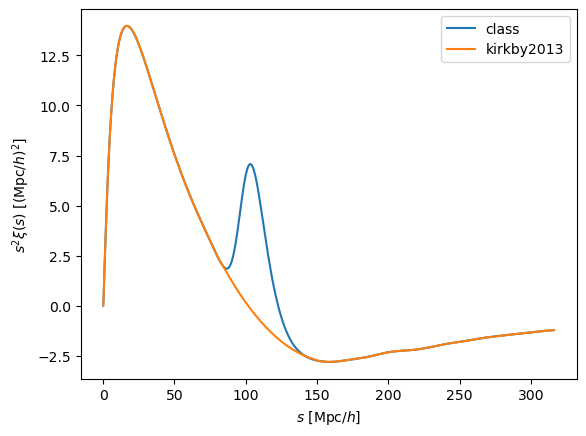

In [21]:
# For the correlation function, the kirkby2013 approach
xinow = CorrelationFunctionBAOFilter(xi, engine='kirkby2013').smooth_xi_interpolator()
s = np.logspace(-2., 2.5, 1000)
z = 1
plt.plot(s, s**2 * xi(s, z=z), label='class')
plt.plot(s, s**2 * xinow(s, z=z), label='kirkby2013')
plt.xlabel(r'$s$ [$\mathrm{Mpc}/h$]')
plt.ylabel(r'$s^{2}\xi(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
plt.legend()
plt.show()

## Modified gravity with ISiTGR
For the following ISiTGR (https://github.com/mishakb/ISiTGR) must be installed with ```pip install isitgr```

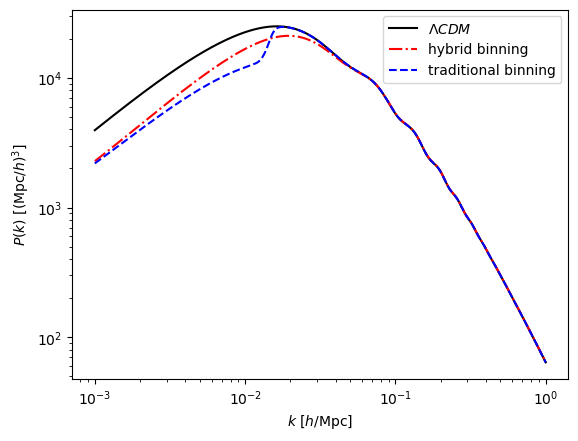

In [22]:
cosmo = Cosmology(engine='isitgr')
cosmo_hybrid = cosmo.clone(parameterization='QD', binning='hybrid', z_div=1, z_TGR=2, z_tw=0.05,
                           k_c=0.01, Q1=1.5, Q2=0.5, Q3=1.5, Q4=0.5, D1=1, D2=1, D3=1, D4=1)
cosmo_trad = cosmo.clone(parameterization='QD', binning='traditional', z_div=1, z_TGR=2, z_tw=0.05,
                         k_c=0.01, Q1=1.5, Q2=0.5, Q3=1.5, Q4=0.5, D1=1, D2=1, D3=1, D4=1, k_tw=0.001)

z = 0.
k = np.logspace(-3., 0., 1000)
pk = cosmo.get_fourier().pk_interpolator().to_1d(z=z)
pk_trad = cosmo_trad.get_fourier().pk_interpolator().to_1d(z=z)
pk_hybrid = cosmo_hybrid.get_fourier().pk_interpolator().to_1d(z=z)


plt.loglog(k, pk(k), color='k', label='$\Lambda CDM$')
plt.loglog(k, pk_hybrid(k), color='r', linestyle='-.', label='hybrid binning')
plt.loglog(k, pk_trad(k), color='b', linestyle='--',label='traditional binning')
plt.legend()
plt.xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
plt.ylabel(r'$P(k)$ [$(\mathrm{Mpc}/h)^{3}$]')
plt.show()

## "Solve" = match cosmology with given observable
Say we want to match a cosmology with e.g. given cosmomc_theta = 1.04092 / 100 or theta_star = 0.0104.

In [23]:
from cosmoprimo.fiducial import DESI

fiducial = DESI()
# theta_MC_100 is already defined internally
cosmo = fiducial.solve('h', 'theta_MC_100', 1.04092)
assert np.allclose(100. * cosmo['theta_cosmomc'], 1.04092)

cosmo = fiducial.solve('h', lambda cosmo: 100. * cosmo.get_thermodynamics().theta_star,
                       target=100. * 0.0104, limits=[0.6, 0.9], xtol=1e-6, rtol=1e-6)
assert np.allclose(cosmo.get_thermodynamics().theta_star, 0.0104)